Starting simulation...
Step 0: t=0.000000s, Rex fraction=0.001, Switched cells=0
Step 10: t=0.000000s, Rex fraction=0.033, Switched cells=7
Step 20: t=0.000000s, Rex fraction=0.114, Switched cells=19
Step 30: t=0.000000s, Rex fraction=0.225, Switched cells=55
Step 40: t=0.000000s, Rex fraction=0.369, Switched cells=81
Step 50: t=0.000000s, Rex fraction=0.506, Switched cells=130
Step 60: t=0.000000s, Rex fraction=0.615, Switched cells=150
Step 70: t=0.000000s, Rex fraction=0.720, Switched cells=116
Step 80: t=0.000000s, Rex fraction=0.825, Switched cells=113
Step 90: t=0.000000s, Rex fraction=0.913, Switched cells=85
Step 100: t=0.000000s, Rex fraction=0.969, Switched cells=47
Step 110: t=0.000000s, Rex fraction=0.997, Switched cells=10
Step 120: t=0.000000s, Rex fraction=1.000, Switched cells=0
Step 130: t=0.000000s, Rex fraction=1.000, Switched cells=721
Step 140: t=0.000000s, Rex fraction=1.000, Switched cells=1625
Step 150: t=0.000000s, Rex fraction=1.000, Switched cells=2401
Step 1

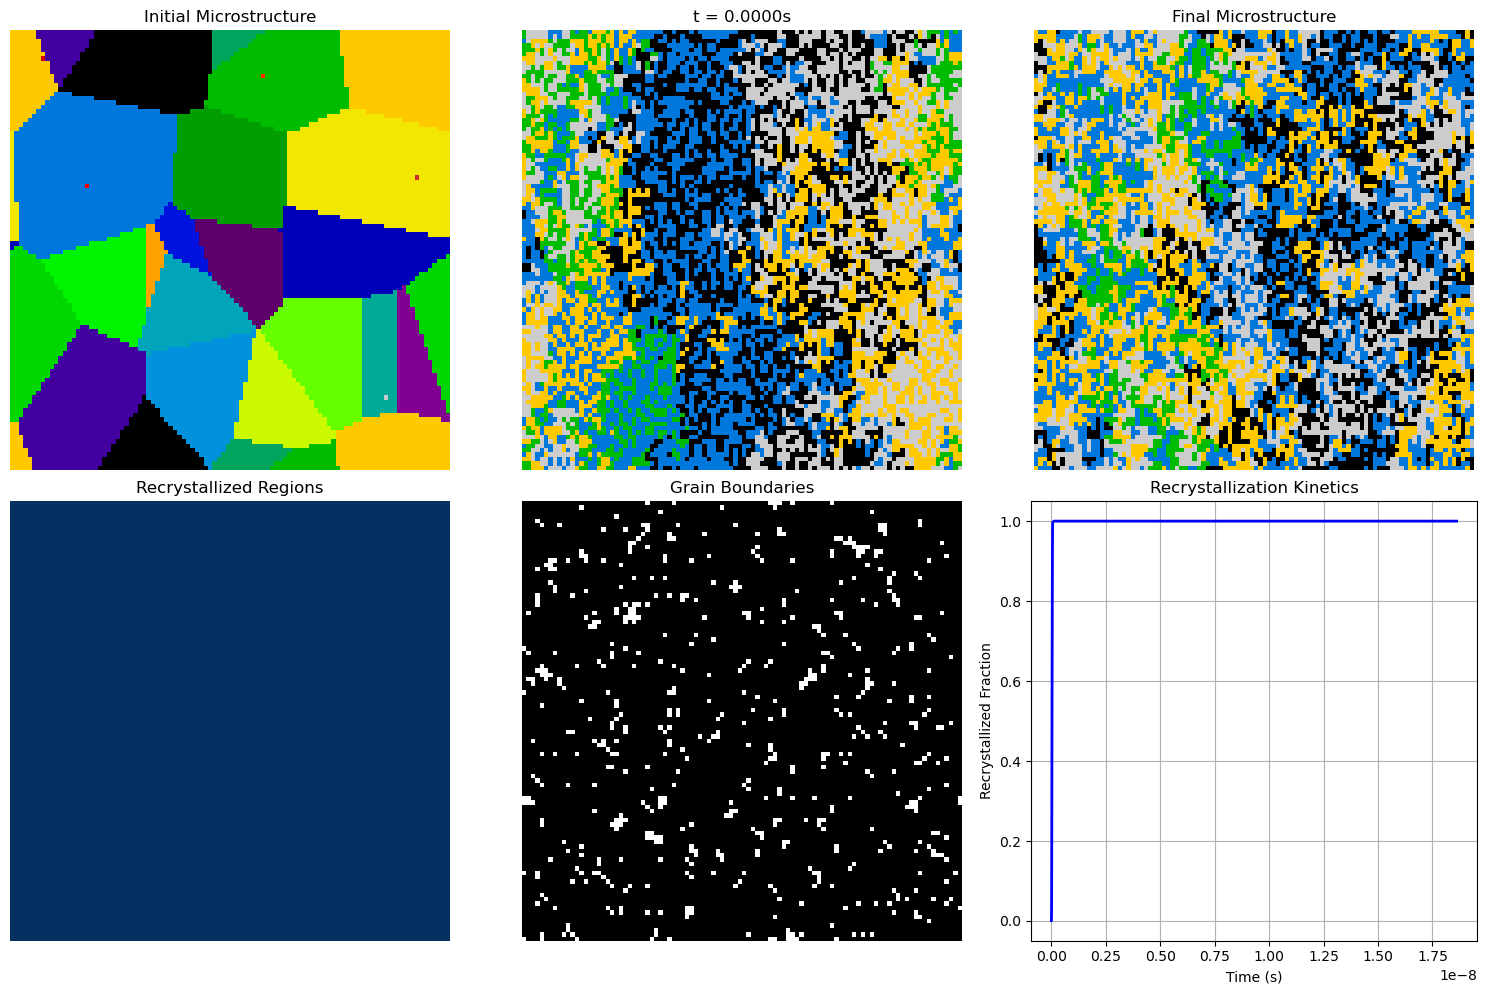

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from dataclasses import dataclass
from typing import List, Tuple, Dict
import random
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

@dataclass
class CellularAutomatonRexGG:
    """
    Cellular Automaton for Recrystallization and Grain Growth
    """
    nx: int = 100
    ny: int = 100
    dx: float = 1e-6  # Cell size in meters
    
    # Material parameters
    grain_boundary_energy: float = 0.5  # J/m^2
    grain_boundary_mobility_0: float = 1e-6  # m^4/(J·s)
    activation_energy: float = 0.0  # J/mol (simplified, T-independent)
    
    # Misorientation parameters
    lower_misorientation_cutoff: float = 2.0  # degrees
    lower_misorientation_lagb: float = 5.0    # degrees
    hagb_threshold: float = 15.0              # degrees
    
    # Simulation parameters
    temperature: float = 873.0  # K
    R: float = 8.314  # J/(mol·K)
    
    # Rex parameters
    stored_energy_factor: float = 1e6  # J/m^3 per unit dislocation density
    
    def __init__(self):
        self.n_cells = self.nx * self.ny
        
        # Cell properties
        self.orientation_id = np.zeros(self.n_cells, dtype=int)
        self.euler_angles = {}  # Dict mapping ori_id to (phi1, Phi, phi2)
        self.is_recrystallized = np.zeros(self.n_cells, dtype=bool)
        self.dislocation_density = np.ones(self.n_cells) * 1e12  # 1/m^2
        self.consumption_rate = np.zeros(self.n_cells)
        self.consumed_fraction = np.zeros(self.n_cells)
        self.neighbor_to_grow = -np.ones(self.n_cells, dtype=int)
        
        # Interface tracking
        self.interface_cells = set()
        
        # Initialize microstructure
        self._initialize_microstructure()
        self._identify_interfaces()
        
    def _initialize_microstructure(self):
        """Initialize with random grain structure and some recrystallization nuclei"""
        # Create initial grain structure
        n_grains = 20
        seed_points = np.random.randint(0, self.n_cells, n_grains)
        
        # Assign orientations using Voronoi-like approach
        for i in range(self.n_cells):
            distances = [self._cell_distance(i, seed) for seed in seed_points]
            nearest_seed_idx = np.argmin(distances)
            self.orientation_id[i] = nearest_seed_idx
            
        # Generate random orientations for each grain
        for grain_id in range(n_grains):
            phi1 = np.random.uniform(0, 360)
            Phi = np.random.uniform(0, 180)
            phi2 = np.random.uniform(0, 360)
            self.euler_angles[grain_id] = (phi1, Phi, phi2)
            
        # Add recrystallization nuclei
        n_nuclei = 5
        rex_sites = np.random.choice(self.n_cells, n_nuclei, replace=False)
        
        for site in rex_sites:
            # Create new orientation for rex grain
            new_ori_id = len(self.euler_angles)
            phi1 = np.random.uniform(0, 360)
            Phi = np.random.uniform(0, 180)
            phi2 = np.random.uniform(0, 360)
            self.euler_angles[new_ori_id] = (phi1, Phi, phi2)
            
            self.orientation_id[site] = new_ori_id
            self.is_recrystallized[site] = True
            self.dislocation_density[site] = 1e10  # Lower dislocation density
            
    def _identify_interfaces(self):
        """Identify grain boundary cells"""
        self.interface_cells.clear()
        
        for i in range(self.n_cells):
            neighbors = self._get_neighbors(i)
            
            for j in neighbors:
                if self.orientation_id[i] != self.orientation_id[j]:
                    mis = self._calculate_misorientation(
                        self.orientation_id[i], 
                        self.orientation_id[j]
                    )
                    if mis >= self.lower_misorientation_lagb:
                        self.interface_cells.add(i)
                        break
                        
    def _get_neighbors(self, cell_idx: int) -> List[int]:
        """Get Von Neumann neighbors (4-connected in 2D)"""
        i, j = self._index_to_ij(cell_idx)
        neighbors = []
        
        # Left, Right, Up, Down
        for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            ni, nj = i + di, j + dj
            
            # Periodic boundary conditions
            ni = ni % self.nx
            nj = nj % self.ny
            
            neighbors.append(self._ij_to_index(ni, nj))
            
        return neighbors
    
    def _get_all_neighbors(self, cell_idx: int) -> List[int]:
        """Get Moore neighbors (8-connected in 2D)"""
        i, j = self._index_to_ij(cell_idx)
        neighbors = []
        
        for di in [-1, 0, 1]:
            for dj in [-1, 0, 1]:
                if di == 0 and dj == 0:
                    continue
                    
                ni, nj = (i + di) % self.nx, (j + dj) % self.ny
                neighbors.append(self._ij_to_index(ni, nj))
                
        return neighbors
    
    def _index_to_ij(self, idx: int) -> Tuple[int, int]:
        return idx // self.ny, idx % self.ny
    
    def _ij_to_index(self, i: int, j: int) -> int:
        return i * self.ny + j
    
    def _cell_distance(self, idx1: int, idx2: int) -> float:
        i1, j1 = self._index_to_ij(idx1)
        i2, j2 = self._index_to_ij(idx2)
        
        # Consider periodic boundaries
        di = min(abs(i1 - i2), self.nx - abs(i1 - i2))
        dj = min(abs(j1 - j2), self.ny - abs(j1 - j2))
        
        return np.sqrt(di**2 + dj**2)
    
    def _calculate_misorientation(self, ori_id1: int, ori_id2: int) -> float:
        """Simplified misorientation calculation"""
        if ori_id1 == ori_id2:
            return 0.0
            
        # Simplified: use difference in first Euler angle
        # In reality, this requires full crystallographic calculations
        euler1 = self.euler_angles[ori_id1]
        euler2 = self.euler_angles[ori_id2]
        
        # Very simplified misorientation
        mis = abs(euler1[0] - euler2[0])
        mis = min(mis, 360 - mis)  # Consider symmetry
        
        # Add some randomness to make it more realistic
        mis += np.random.uniform(-5, 5)
        mis = max(0, min(mis, 62.8))  # Cap at theoretical maximum
        
        return mis
    
    def _get_boundary_energy(self, misorientation: float) -> float:
        """Read-Shockley boundary energy model"""
        if misorientation < self.lower_misorientation_cutoff:
            return 0.0
            
        r = misorientation / self.hagb_threshold
        if r >= 1.0:
            return self.grain_boundary_energy
            
        return self.grain_boundary_energy * r * (1 - np.log(r))
    
    def _get_mobility(self, misorientation: float) -> float:
        """Misorientation-dependent mobility (Humphreys model)"""
        if misorientation < self.lower_misorientation_cutoff:
            return 0.0
            
        # Temperature dependence (simplified here)
        M0 = self.grain_boundary_mobility_0
        
        r = misorientation / self.hagb_threshold
        if r >= 1.0:
            return M0
            
        # Humphreys parameters
        B = 5.0
        n = 4.0
        
        return M0 * (1 - np.exp(-B * r**n))
    
    def calculate_consumption_rates(self) -> float:
        """Calculate consumption rates for all interface cells"""
        max_rate = 0.0
        
        # Reset rates
        self.consumption_rate.fill(0.0)
        self.neighbor_to_grow.fill(-1)
        
        for cell_idx in self.interface_cells:
            # Current cell properties
            current_ori = self.orientation_id[cell_idx]
            neighbors = self._get_all_neighbors(cell_idx)
            
            # Calculate current boundary energy
            current_energy = 0.0
            for nbr in neighbors:
                mis = self._calculate_misorientation(
                    current_ori, 
                    self.orientation_id[nbr]
                )
                current_energy += self._get_boundary_energy(mis)
            
            # Add stored energy from dislocations (driving force for Rex)
            stored_energy = self.stored_energy_factor * self.dislocation_density[cell_idx]
            
            # Try each neighbor as potential new orientation
            best_rate = 0.0
            best_neighbor = -1
            
            for growth_nbr in self._get_neighbors(cell_idx):
                if self.orientation_id[growth_nbr] == current_ori:
                    continue
                    
                growth_ori = self.orientation_id[growth_nbr]
                growth_mis = self._calculate_misorientation(current_ori, growth_ori)
                
                if growth_mis < self.lower_misorientation_lagb:
                    continue
                
                # Calculate new energy state
                new_energy = 0.0
                for nbr in neighbors:
                    mis = self._calculate_misorientation(
                        growth_ori,
                        self.orientation_id[nbr]
                    )
                    new_energy += self._get_boundary_energy(mis)
                
                # Driving force
                driving_force = current_energy - new_energy + stored_energy
                
                if driving_force <= 0:
                    continue
                
                # Calculate mobility
                mobility = self._get_mobility(growth_mis)
                
                # Consumption rate
                rate = mobility * driving_force
                
                if rate > best_rate:
                    best_rate = rate
                    best_neighbor = growth_nbr
            
            self.consumption_rate[cell_idx] = best_rate
            self.neighbor_to_grow[cell_idx] = best_neighbor
            
            if best_rate > max_rate:
                max_rate = best_rate
                
        return max_rate
    
    def update_cells(self, dt: float) -> int:
        """Update cell orientations based on consumption"""
        n_switched = 0
        cells_to_update = []
        
        # Update consumed fractions
        for cell_idx in self.interface_cells:
            if self.consumption_rate[cell_idx] > 0:
                self.consumed_fraction[cell_idx] += self.consumption_rate[cell_idx] * dt
                
                if self.consumed_fraction[cell_idx] >= 1.0:
                    cells_to_update.append(cell_idx)
        
        # Switch cells that are fully consumed
        for cell_idx in cells_to_update:
            growth_nbr = int(self.neighbor_to_grow[cell_idx])
            if growth_nbr >= 0:
                # Switch orientation
                self.orientation_id[cell_idx] = self.orientation_id[growth_nbr]
                
                # Update rex status
                if self.is_recrystallized[growth_nbr]:
                    self.is_recrystallized[cell_idx] = True
                    self.dislocation_density[cell_idx] = 1e10  # Low dislocation density
                
                # Reset consumption
                self.consumed_fraction[cell_idx] = 0.0
                self.neighbor_to_grow[cell_idx] = -1
                
                n_switched += 1
        
        # Update interfaces if cells switched
        if n_switched > 0:
            self._identify_interfaces()
            
        return n_switched
    
    def simulate_step(self) -> Tuple[float, int]:
        """Perform one simulation step"""
        # Calculate rates
        max_rate = self.calculate_consumption_rates()
        
        if max_rate <= 0:
            return 0.0, 0
        
        # Calculate time step
        dt = 0.5 / max_rate  # Safety factor of 0.5
        
        # Update cells
        n_switched = self.update_cells(dt)
        
        return dt, n_switched
    
    def get_microstructure_map(self) -> np.ndarray:
        """Get 2D orientation map"""
        return self.orientation_id.reshape(self.nx, self.ny)
    
    def get_rex_map(self) -> np.ndarray:
        """Get 2D recrystallization map"""
        return self.is_recrystallized.reshape(self.nx, self.ny)
    
    def get_interface_map(self) -> np.ndarray:
        """Get 2D interface map"""
        interface_array = np.zeros(self.n_cells, dtype=bool)
        for idx in self.interface_cells:
            interface_array[idx] = True
        return interface_array.reshape(self.nx, self.ny)

def run_simulation():
    """Run the Rex/GG simulation"""
    # Create CA
    ca = CellularAutomatonRexGG()
    
    # Simulation parameters
    max_steps = 500
    total_time = 0.0
    
    # Storage for visualization
    history = {
        'time': [0.0],
        'rex_fraction': [np.mean(ca.is_recrystallized)],
        'microstructure': [ca.get_microstructure_map().copy()]
    }
    
    # Run simulation
    print("Starting simulation...")
    for step in range(max_steps):
        dt, n_switched = ca.simulate_step()
        total_time += dt
        
        if step % 10 == 0:
            rex_frac = np.mean(ca.is_recrystallized)
            history['time'].append(total_time)
            history['rex_fraction'].append(rex_frac)
            history['microstructure'].append(ca.get_microstructure_map().copy())
            
            print(f"Step {step}: t={total_time:.6f}s, "
                  f"Rex fraction={rex_frac:.3f}, "
                  f"Switched cells={n_switched}")
        
        if n_switched == 0 and dt == 0:
            print("Simulation reached steady state")
            break
    
    return ca, history

def visualize_results(ca, history):
    """Visualize simulation results"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Initial microstructure
    axes[0, 0].imshow(history['microstructure'][0], cmap='nipy_spectral')
    axes[0, 0].set_title('Initial Microstructure')
    axes[0, 0].axis('off')
    
    # Intermediate
    mid_idx = len(history['microstructure']) // 2
    axes[0, 1].imshow(history['microstructure'][mid_idx], cmap='nipy_spectral')
    axes[0, 1].set_title(f"t = {history['time'][mid_idx]:.4f}s")
    axes[0, 1].axis('off')
    
    # Final microstructure
    axes[0, 2].imshow(history['microstructure'][-1], cmap='nipy_spectral')
    axes[0, 2].set_title('Final Microstructure')
    axes[0, 2].axis('off')
    
    # Rex map
    axes[1, 0].imshow(ca.get_rex_map(), cmap='RdBu_r')
    axes[1, 0].set_title('Recrystallized Regions')
    axes[1, 0].axis('off')
    
    # Interface map
    axes[1, 1].imshow(ca.get_interface_map(), cmap='gray_r')
    axes[1, 1].set_title('Grain Boundaries')
    axes[1, 1].axis('off')
    
    # Rex kinetics
    axes[1, 2].plot(history['time'], history['rex_fraction'], 'b-', linewidth=2)
    axes[1, 2].set_xlabel('Time (s)')
    axes[1, 2].set_ylabel('Recrystallized Fraction')
    axes[1, 2].set_title('Recrystallization Kinetics')
    axes[1, 2].grid(True)
    
    plt.tight_layout()
    plt.show()

# Run the simulation
if __name__ == "__main__":
    ca, history = run_simulation()
    visualize_results(ca, history)
    